### Puxando dados

In [4]:
import json

dados = []
with open("Atas_Copom_275-21(2).jsonl", "r", encoding="utf-8") as f:
    for linha in f:
        dados.append(json.loads(linha))



#### Ordenando por reunião

In [ ]:
import pandas as pd
dados = sorted(dados, key=lambda d: d['N°'])


df = pd.DataFrame(dados)

#### Corrigindo as datas

In [ ]:
datas_reunioes = pd.read_excel('datas_reuniões_copom.xlsx')

mapa_meses = {
    "jan": "Jan", "fev": "Feb", "mar": "Mar", "abr": "Apr",
    "mai": "May", "jun": "Jun", "jul": "Jul", "ago": "Aug",
    "set": "Sep", "out": "Oct", "nov": "Nov", "dez": "Dec"
}


datas_reunioes['data_norm'] = (
    datas_reunioes['data']
    .str.lower()
    .replace(mapa_meses, regex=True)
)


datas_reunioes['data_norm'] = pd.to_datetime(datas_reunioes['data_norm'])


In [10]:

df['data_reunião'] = datas_reunioes['data_norm']

### Limpeza Superficial dos Dados

##### Criando Função

In [ ]:
def limpa_estrutura(texto):
    # 1. Proteção absoluta
    if not isinstance(texto, str):
        return ""

    texto = texto.strip()
    if texto == "":
        return ""

    marcador_inicio = 'evolução recente'
    

    # 2. Corte inicial seguro
    if marcador_inicio in texto.lower():
        partes = texto.split(marcador_inicio, 1)
        if len(partes) == 2:
            texto = marcador_inicio + partes[1]

    # # 3. Corte final seguro
    # if marcador_fim in texto:
    #     partes = texto.split(marcador_fim, 1)
    #     texto = partes[0]

    return texto.strip()



##### Aplicando-a

In [ ]:

df['conteudo_limpo'] = df['conteudo'].apply(limpa_estrutura)


### Criando índice Hawk

In [ ]:

import re

Ht = [
    "inflação acima da meta",
    "inflação elevada",
    "inflação persistente",
    "pressões inflacionárias",
    "dinâmica inflacionária",
    "persistência inflacionária",
    "expectativas desancoradas",
    "desancoragem das expectativas",
    "restrição monetária",
    "política monetária contracionista",
    "postura contracionista",
    "ajuste das condições monetárias",
    "continuidade do ajuste",
    "elevação dos preços",
    "aceleração dos preços",
    "choques identificados",
    "impactos adversos",
    "riscos à inflação",
    "preservação das conquistas"
]

Dt = [
    "inflação comportada",
    "inflação sob controle",
    "convergência da inflação",
    "cumprimento da meta",
    "expectativas ancoradas",
    "expectativas em linha com as metas",
    "estabilidade das expectativas",
    "capacidade ociosa",
    "alto nível de ociosidade",
    "política monetária estimulativa",
    "estímulo monetário",
    "flexibilização da política monetária",
    "redução da taxa selic",
    "não se observaram pressões inflacionárias",
    "cenário benigno",
    "cumprindo a meta",
    "redução da taxa de juros"
]




def hawk(texto:str):
    qtd_total = 0
    
    for hi in Ht:
        lista = re.findall(hi, texto)
        qtd = len(lista)
        
        qtd_total += qtd
        
        
        
    return qtd_total


def dov(texto: str):
    qtd_total = 0
    
    for di in Dt:
        lista = re.findall(di, texto)
        qtd = len(lista)
        
        qtd_total += qtd
        
        
        
    return qtd_total
    
    

def calcula_hd(texto:str):
    ht = hawk(texto)
    dt = dov(texto)
    
    ind = (ht-dt)/(ht+dt+1)
    
    return ind

    

#### Aplicando Função

In [15]:
df['hd_index'] = df['conteudo_limpo'].apply(calcula_hd)

#### Criando Gráfico

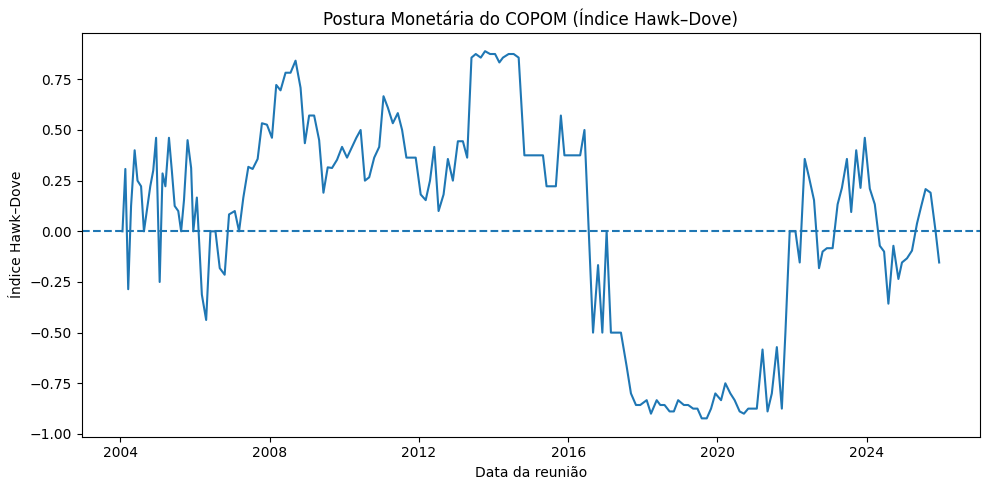

In [16]:
import matplotlib.pyplot as plt

# garantir ordenação temporal
df = df.sort_values("data_reunião")

# filtrar a partir de 2004
df_plot = df[df["data_reunião"] >= "2004-01-01"].sort_values("data_reunião")

plt.figure(figsize=(10, 5))
plt.plot(df_plot["data_reunião"], df_plot["hd_index"])
plt.axhline(0, linestyle="--")  # linha de referência
plt.xlabel("Data da reunião")
plt.ylabel("Índice Hawk–Dove")
plt.title("Postura Monetária do COPOM (Índice Hawk–Dove)")
plt.tight_layout()
plt.show()


### Criando Indice de íncerteza Comunicacional

In [17]:
UNC_terms = [
    "incerteza", "incertezas",
    "risco", "riscos",
    "assimetria", "assimétrico",
    "volatilidade", "volátil",
    "cautela", "prudência",
    "dependerá", "dependem",
    "condicional", "condicionalmente",
    "cenário alternativo", "cenários alternativos",
    "eventual", "eventualmente",
    "possibilidade", "possibilidades",
    "avaliará", "monitorará", "acompanhará",
    "poder", "poderá", "deverá", "tende", "dependerá", "caso", "se",
    "choque", "deterioração", "pressão",
    "expectativa", "expectativas", "projeção", "projeções",
    "cenário", "cenários", "cenário central", 
    "acompanhar", "monitorar", "reavaliar", "caso necessário"
]




def un(texto: str):
    qtd_total = 0
    
    for termos in UNC_terms:
        lista = re.findall(termos, texto)
        qtd = len(lista)
        
        qtd_total += qtd
        
    tamanho = len(texto.split())
        
    return (qtd_total/tamanho)

#### Aplicando Função

In [18]:
df['un_index'] = df['conteudo_limpo'].apply(un)

#### Criando Gráfico

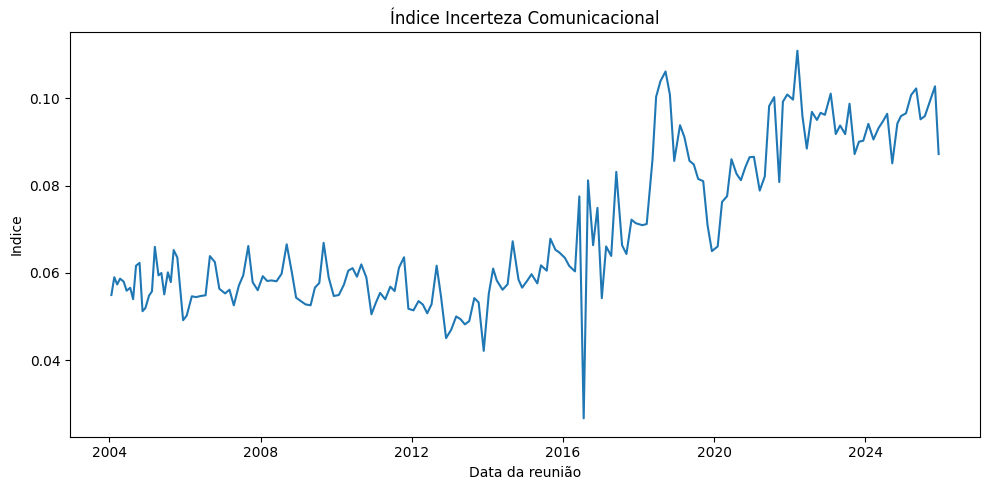

In [19]:
# garantir ordenação temporal
df = df.sort_values("data_reunião")

# filtrar a partir de 2004
df_plot = df[df["data_reunião"] >= "2004-01-01"].sort_values("data_reunião")

plt.figure(figsize=(10, 5))
plt.plot(df_plot["data_reunião"], df_plot["un_index"])

plt.xlabel("Data da reunião")
plt.ylabel("Indice")
plt.title("Índice Incerteza Comunicacional")
plt.tight_layout()
plt.show()

### Calculando Gap

In [ ]:

selic = pd.read_excel('selic.xlsx')
print(selic)


mapa_meses = {
    "jan": "Jan", "fev": "Feb", "mar": "Mar", "abr": "Apr",
    "mai": "May", "jun": "Jun", "jul": "Jul", "ago": "Aug",
    "set": "Sep", "out": "Oct", "nov": "Nov", "dez": "Dec"
}


selic['data_reunião'] = (
    selic['data']
    .str.lower()
    .replace(mapa_meses, regex=True)
)


selic['data_reunião'] = pd.to_datetime(selic['data_reunião'])

In [ ]:

df = df.merge(selic, how='inner',on=['data_reunião'])

In [45]:
df["HD_lag"] = df["hd_index"].shift(1)
df["UNC_lag"] = df["un_index"].shift(1)
df['var_selic_lag'] =df['var_selic'].shift(1)

df_model = df.dropna(subset=["var_selic", "HD_lag", "UNC_lag", 'var_selic_lag','N°'])
df_model = df_model[df_model['data_reunião'] >= '2005-01-01']

In [46]:
import statsmodels.api as sm

X = df_model[["HD_lag"]]
X = sm.add_constant(X)

y = df_model["var_selic"]

model = sm.OLS(y, X).fit()
print(model.summary())


df_model["var_selic_prev"] = model.predict(X)

df_model["comm_gap"] = (
    df_model["var_selic"] - df_model["var_selic_prev"]
)


                            OLS Regression Results                            
Dep. Variable:              var_selic   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.370
Date:                Thu, 18 Dec 2025   Prob (F-statistic):              0.126
Time:                        17:13:59   Log-Likelihood:                -131.48
No. Observations:                 171   AIC:                             267.0
Df Residuals:                     169   BIC:                             273.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0241      0.040     -0.599      0.5

In [50]:

df_site = df.merge(df_model[['comm_gap','N°']], how='inner',on=['N°'])

df_site.to_excel('Site/dados.xlsx')

### alinhamento discurso–ação

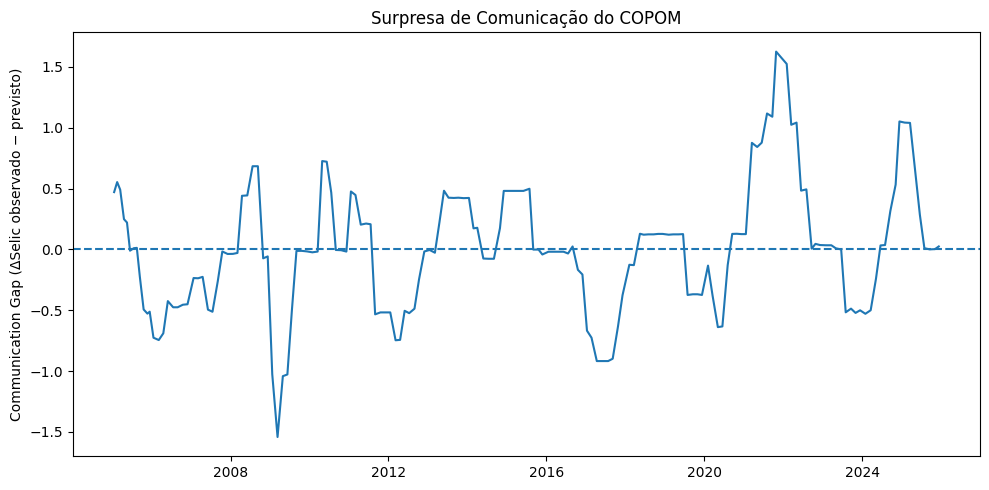

In [44]:
plt.figure(figsize=(10,5))
plt.plot(df_model["data_reunião"], df_model["comm_gap"])
plt.axhline(0, linestyle="--")
plt.title("Surpresa de Comunicação do COPOM")
plt.ylabel("Communication Gap (ΔSelic observado − previsto)")
plt.tight_layout()
plt.show()